In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import csv
import pandas
import random
import keras.preprocessing.image
from PIL import Image 
import warnings
from sklearn.utils import shuffle
import pickle
from IPython.display import HTML
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
print("Keras Version:",keras.__version__)
print("Tensorflow Version:",tf.__version__)

Keras Version: 2.2.4
Tensorflow Version: 1.14.0


**In this Project we're going to learn about behavioral cloning. First I am going to drive a car through simulating myself and then you make a neural network wich will watch me and copy me to drive the vehicle autonomous.The task for the neural network is to pick up my driving skill and copy it and do the same.**


### How to collect data

Data is collected with [Udacity self-driving car simulator](https://github.com/udacity/self-driving-car-sim) (see Image below), which has two modes(training and autonomous) and two tracks.In the training mode, the simulator captures images from three cameras mounted on the car: a center, right and left camera. That’s because of the issue of recovering from being off-center. In the simulator, you can weave all over the road and turn recording on and off to record recovery driving. In a real car, however, that’s not really possible. At least not legally. So in a real car, we’ll have multiple cameras on the vehicle, and we’ll map recovery paths from each camera. For example, if you train the model to associate a given image from the center camera with a left turn, then you could also train the model to associate the corresponding image from the left camera with a somewhat softer left turn and you could train the model to associate the corresponding image from the right camera with an even harder left turn. In that way, you can simulate your vehicle being in different positions, somewhat further off the center line(see below image). To read more about this approach, see this [paper](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) by our friends at NVIDIA that makes use of this technique.



<p align="center"> <img src="./img/2.PNG" style="right;" alt=" udacity self-driving car simulator" width="600" height="400"> </p> 

### Explanation of How Multiple Cameras Work

The image below gives a sense for how multiple cameras are used to train a self-driving car. This image shows a bird's-eye perspective of the car. The driver is moving forward but wants to turn towards a destination on the left.From the perspective of the left camera, the steering angle would be less than the steering angle from the center camera. From the right camera's perspective, the steering angle would be larger than the angle from the center camera. 



<p align="center"> <img src="./img/1.PNG" style="right;" alt=" Explanation of How Multiple Cameras Work" width="600" height="400"> </p> 


When recording, the simulator will simultaneously save an image for the left, center and right cameras. Each row of the csv log file (driving_log.csv) contains the file path for each camera as well as information about the steering measurement, throttle, brake and speed of the vehicle.

During training, you want to feed the left and right camera images to your model as if they were coming from the center camera. This way, you can teach your model how to steer if the car drifts off to the left or the right and during prediction ("autonomous mode"), you only need to predict with the center camera image.


### Data Collection Strategy

If you drive and record normal laps around the track, even if you record a lot of them, it might not be enough to train your model to drive properly. Here’s the problem: if your training data is all focused on driving down the middle of the road, our model won’t ever learn what to do if it gets off to the side of the road and probably when you run your model to predict steering measurements, things won’t go perfectly and the car will wander off to the side of the road at some point.

As the human driver, you can weave back and forth between the middle of the road and the shoulder, but you need to turn off data recording when you weave out to the side, and turn it back on when you steer back to the middle.

As konwn, the vehicle's driving behavior is only as good as the behavior of the driver who provided the data for this reason i implement the below presented strategy to collect accurate data:

1. The car should be driven percisely in the center of the track 1 as much as possible for 2 lap( smoothly around curves).
    
2. The car should be driven counter-clockwise in the center of  the track 1 as much as possible for 1 lap which can help to the generalization of the model.
    
3. The car should be driven clockwise and counter-clockwise on the second track which can help to avoid overfitting or underfitting when training the model.
    
4. A better approach is to record data when the car is driving (clockwise and counter-clockwise) from the side of the road back toward the center line(recovery driving from the sides).
    


# Load Data

Firs I am going to use the load_csv function to read each line of the csv file, Second by using the load_image function I am going to load the images and steering angles of samples.



In [4]:
def load_csv(data_path):
    lines=[]
    data_path=data_path+'driving_log.csv'
    with open(data_path) as csvfile:
        reader=csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

In [5]:
def load_image(data_path):
    car_images=[]
    steering_angles=[]
    
    with open(data_path+'driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        headers = next(reader) 
        for row in reader:
            
            steering_center = float(row[3])

            # create adjusted steering measurements for the side camera images
            correction = 0.025 # this is a parameter to tune
            steering_right = steering_center - correction
            steering_left = steering_center + correction


            #the path to your training IMG directory
            center_path=data_path+ row[0].strip() 
            left_path=data_path+ row[1].strip()
            right_path=data_path+row[2].strip()
            
            # read in images from center, left and right cameras
            img_center = np.asarray(Image.open(center_path))
            img_left = np.asarray(Image.open(left_path))
            img_right = np.asarray(Image.open(right_path))
                
            # add images and angles to data set
            for img,steer in zip([img_left,img_center,img_right],[steering_left,steering_center,steering_right]):
                car_images.append(img)
                steering_angles.append(steer)
    return np.array(car_images),np.array(steering_angles)

In [6]:
#the path to your data folder which has  IMG and driving_log.csv inside
data_path='C:/Users/ziaeeamir/Desktop/Self_driving Car/Behavioral cloning/data/data/'
car_images,steering_angles=load_image(data_path)
print('The number of images befor datset balancing :', car_images.shape)
print('The number of steering angles befor datset balancing :', steering_angles.shape)



The number of images befor datset balancing : (24108, 160, 320, 3)
The number of steering angles befor datset balancing : (24108,)


# Data Visulization

The udacity simulator collects three different images (Center Image,Left Image,Right Image)and corresponding steering angle and logs into a folder with csv file having each image location with the steering angle.

In [7]:
df=pandas.DataFrame(load_csv(data_path)[1:],columns=load_csv(data_path)[:1][0],dtype='float')
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


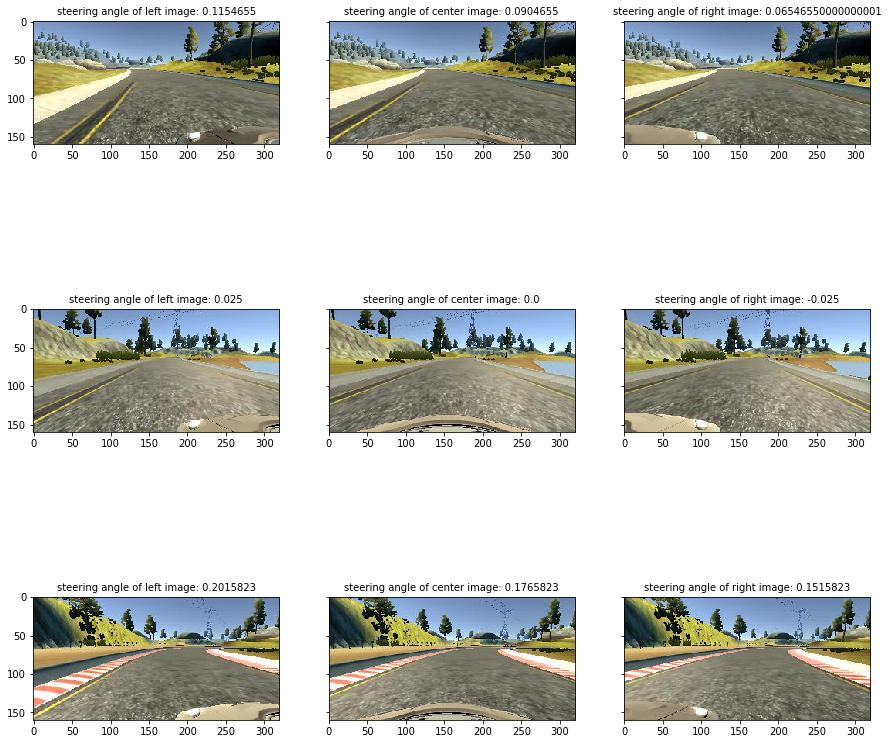

In [8]:
from random import randint
from random import seed

rows = 3
cols = 3
fig, axis = plt.subplots(rows,cols,sharey=True)
fig.set_size_inches(15,15)
for i in range(3):
    
    index=random.choice(range(0, car_images.shape[0], 3))
    
    left_img=car_images[index] 
    center_img=car_images[index+1] 
    right_img=car_images[index+2] 
    
    axis[i][0].imshow(left_img)
    axis[i][1].imshow(center_img)
    axis[i][2].imshow(right_img)
    
    axis[i][0].set_title('steering angle of left image: '+str(steering_angles[index]),fontsize=10)
    axis[i][1].set_title('steering angle of center image: '+str(steering_angles[index+1]),fontsize=10)
    axis[i][2].set_title('steering angle of right image: '+ str(steering_angles[index+2]),fontsize=10)
    


In [9]:

print('The image size: {}'.format(car_images[0].shape))
print('the number of the images: {} '.format(car_images.shape))
print('the number of the steering angles {} '.format(steering_angles.shape))


The image size: (160, 320, 3)
the number of the images: (24108, 160, 320, 3) 
the number of the steering angles (24108,) 


# Dataset Balancing

After loading data I ended up with 24108 images. But looking at steering angle distribution it looks like most of the image have zero or close to zero steering angle and because the training track includes long sections with very slight or no curvature, the data captured from it tends to be heavily skewed toward low and zero turning angles. This creates a problem for the neural network, which then becomes biased toward driving in a straight line and can become easily confused by sharp turns. The distribution of the input data can be observed below, the black line represents what would be a uniform distribution of the data points.


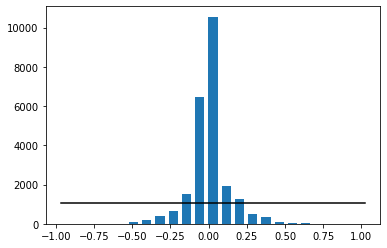

In [10]:
# print a histogram to see which steering angle ranges are most overrepresented

num_bins = 23
avg_samples_per_bin = len(steering_angles)/num_bins
hist, bins = np.histogram(steering_angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

#### As you can see data is not a normal distribution or gaussian  To overcome this problem I used the two following method to correct the data.

To reduce the occurrence of low and zero angle data points, I first chose a number of bins (I decided upon 23) and produced a histogram of the turning angles using numpy.histogram. I also computed the average number of samples per bin (avg_samples_per_bin - what would be a uniform distribution) and plotted them together. Next, I determined a "keep probability" (keep_prob) for the samples belonging to each bin. That keep probability is 1.0 for bins that contain less than avg_samples_per_bin, and for other bins the keep probability is calculated to be the number of samples for that bin divided by avg_samples_per_bin (for example, if a bin contains twice the average number of data points its keep probability will be 0.5). Finally, I removed random data points from the data set with a frequency of (1 - keep_prob).





The resulting data distribution can be seen in the chart below. The distribution is not uniform overall, but it is much closer to uniform for lower and zero turning angles.



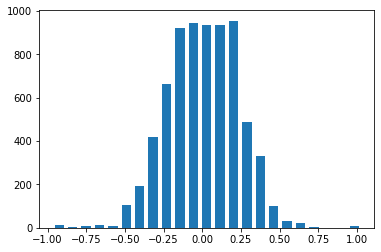

In [11]:
keep_probs = []
target = avg_samples_per_bin * .9
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(steering_angles)):
    for j in range(num_bins):
        if steering_angles[i] > bins[j] and steering_angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)

car_images = np.delete(car_images, remove_list, axis=0)
steering_angles = np.delete(steering_angles, remove_list)

hist, bins = np.histogram(steering_angles, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.show()



In [12]:
print('The number of images After datset balancing :', car_images.shape)
print('The number of steering angles After datset balancing :', steering_angles.shape)

The number of images After datset balancing : (7084, 160, 320, 3)
The number of steering angles After datset balancing : (7084,)


# Data Augmentation

As you can see above, the number of our dataset has decreased from 24108 to 7084, indicating the need for data augmentation to address the challenge of small datasets. To overcome this challenge I implement tow strategies presented below:
1. I used histogram equalization to equalize each intensity values
2. Flipping Images and Steering angles  by using keras preprocessing image function, which is a effective technique for helping with the left turn bias involves flipping images and taking the opposite sign of the steering angle.

In [13]:
def hisEquColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
    channels=cv2.split(ycrcb)
    #print(len(channels))
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)
    return img

Text(0.5, 1.0, 'Image after histogram Equalization')

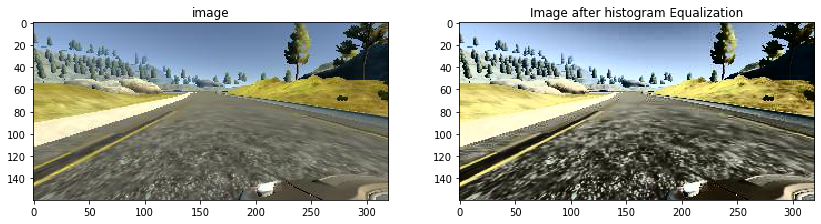

In [14]:
figure,ax= plt.subplots(nrows=1, ncols=2,figsize=(14,8))
index=random.choice(range(0, car_images.shape[0]))

ax[0].imshow(car_images[index])
ax[0].set_title("image")
ax[1].imshow(hisEquColor(car_images[index]))
ax[1].set_title("Image after histogram Equalization")


Text(0.5, 1.0, 'The flipped Image and its steering angle 0.2211613')

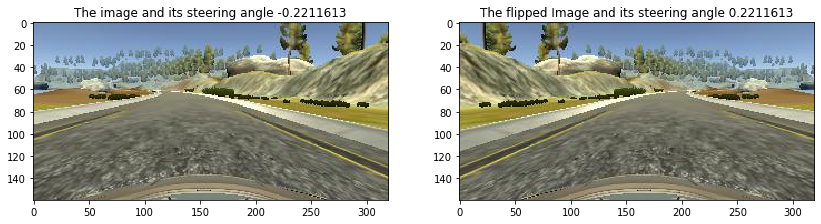

In [15]:
figure,ax= plt.subplots(nrows=1, ncols=2,figsize=(14,8))
index=random.choice(range(0, car_images.shape[0]))

ax[0].imshow(car_images[index])
ax[0].set_title("The image and its steering angle "+str(steering_angles[index]))
ax[1].imshow(keras.preprocessing.image.image.flip_axis(car_images[index],1))
ax[1].set_title("The flipped Image and its steering angle "+str(-steering_angles[index]))

# Generator

In this section I will create a generator by using the train_test_split function from the sklearn library which splites dataset into train and validation samples that will be used to feed data into the model.


In [16]:
def generator(data,labels,batch_size=32):
    number_samples=len(data)
    while 1:
        #r = random.random()            # randomly generating a real in [0,1)
        #random.shuffle(data, lambda : r)  # lambda : r is an unary function which returns r
        #random.shuffle(labels, lambda : r)
        data,labels = shuffle(data,labels)
        for offset in range(0,number_samples,batch_size):
            #print(offset)
            images=[]
            angles=[]
            x_samples=data[offset:offset+batch_size]
            y_samples=labels[offset:offset+batch_size]
            for x,y in zip(x_samples,y_samples):
                #print(x.shape,y.shape)

                #Augmentation
                if np.random.uniform()>=0.5:
                    x=hisEquColor(x)
                    y=y

                        
                elif np.random.uniform()>=0.6:
                    x=keras.preprocessing.image.image.flip_axis(x,1)
                    y=-y

                images.append(x)
                angles.append(y)
            yield shuffle(np.array(images),np.array(angles))


In [17]:
x_train, x_test, y_train, y_test = train_test_split(car_images, steering_angles, train_size=0.65,test_size=0.35, random_state=101)

x_train_gen,y_train_gen=[],[]
x_train_gen,y_train_gen=next(generator(x_train,y_train,batch_size=256))
print(x_train_gen.shape)
#plt.imshow(x_train_gen[255])
#y_train_gen[255]

(256, 160, 320, 3)


In [18]:
train_generator=generator(x_train,y_train,batch_size=32)
validation_generator=generator(x_test,y_test,batch_size=32)

# Model

I used the below explained  architecture that include;

* First,I cropped all the unneeded part of the image( at the top of all the images are sky-mountain-forest and the hood of the car at the bottom).

* Second I used a lambda layer which is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will normalize input images when making predictions.
    


* Then I used 2 Block(as layer 3 and 4) where each block consists of the 2 Residual modules of ResNet(titled “Deep Residual Learning for Image Recognition”) with batch normalization and max pooling layer then foollowed by 1 Flatten layer and 4 dense layer with activation ELU and using dropout to not overfit the network,
    
 * Optimizer Adam with learning rate 1e-4 instead of default 1e-3.



Keras provides the Cropping2D layer for image cropping within the model. This is relatively fast, because the model is parallelized on the GPU, so many images are cropped simultaneously.By contrast, image cropping outside the model on the CPU is relatively slow.

Also, by adding the cropping layer, the model will automatically crop the input images when making predictions in drive.py. The Cropping2D layer might be useful for choosing an area of interest that excludes the sky and/or the hood of the car.The cropping layer crops:

* 60 rows pixels from the top of the image
* 20 rows pixels from the bottom of the image
* 0 columns of pixels from the left of the image
* 0 columns of pixels from the right of the image







In [19]:
from keras.layers import Lambda,Conv2D,MaxPooling2D,Flatten,Cropping2D,Input,Activation,add,Dense,Dropout,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MSE
from keras.utils import plot_model
import pydot

In [20]:
def residual_module(layer_in,n_filters,name):
    merge_input=layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input=Conv2D(n_filters,(1,1),padding='same',activation='relu' ,kernel_initializer='he_normal')(layer_in)
    conv1=Conv2D(n_filters,(3,3),name=name+"Conve1",padding='same',activation='relu',kernel_initializer='he_normal')(layer_in)
    conv2=Conv2D(n_filters,(3,3),name=name+"Conve2",padding='same',activation='linear',kernel_initializer='he_normal')(conv1)
    adding_layer=add([conv2,merge_input])
    activation_layer=Activation('relu',name=name)(adding_layer)
    layer_out=BatchNormalization()(activation_layer)

    return layer_out


# define model input
model_input = Input(shape=(160, 320, 3),name="Input_layer")

layer1=Cropping2D(cropping=((60,20),(0,0)),input_shape=(160,320,3),name="Cropping_Layer")(model_input)
layer2=Lambda(lambda x:(x/255.0)-0.5)(layer1)

layer3 = residual_module(layer2, 64,name="Residual_Module_1")
layer3=MaxPooling2D((6,5),strides=2) (layer3)


layer4 = residual_module(layer3, 128,name="Residual_Module_2")
layer4=MaxPooling2D((4,4),strides=2) (layer4)

Flatten=Flatten(name="Flatten_Layer")(layer4)
layer5=Dense(128,name="Dense_Layer_1")(Flatten)
layer5=Activation('elu')(layer5)
layer5=Dropout(0.5)(layer5)


layer6=Dense(64,name="Dense_Layer_2")(layer5)
layer6=Activation('elu')(layer6)
layer6=Dropout(.5)(layer6)



layer7=Dense(32,name="Dense_Layer_3")(layer6)
layer7=Activation('elu')(layer7)
layer7=Dropout(.5)(layer7)

layer8=Dense(1,name="Dense_Layer_4")(layer7)

model = Model(inputs=model_input, outputs=layer8)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='img/3.png', show_shapes=True, show_layer_names=True)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
Cropping_Layer (Cropping2D)     (None, 80, 320, 3)   0           Input_layer[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 80, 320, 3)   0           Cropping_Layer[0][0]             
__________________________________________________________________________________________________
Residual_Module_1Conve1 (Conv2D (None, 80, 320, 64)  1792        lambda_1[0][0]       

<p align="center"> <img src="./img/3_1.png" style="right;" alt="Architecture" width="300" height="500"> </p> 

Since this model outputs a single continuous numeric value, one appropriate error metric would be mean squared error. If the mean squared error is high on both a training and validation set, the model is underfitting. If the mean squared error is low on a training set but high on a validation set, the model is overfitting. Collecting more data can help improve a model when the model is overfitting.

In [21]:
adam=Adam(lr=1e-4)
model.compile(optimizer=adam,loss=MSE,metrics=['accuracy'])

# Train Model

I train model with the generator and Parameters I used in my model:

* No of epochs: 5
* Optimizer Used: Adam
* Learning Rate: 1e-4
* Validation Data split: 0.2
* Generator batch size: 32
* Correction factor: 0.25 and -0.25
* Loss Function Used: MSE(Mean Squared Error as it is efficient for regression problem).
* Activation Function: RELU and ELU
* Dropout: 50% 



In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
file='model1.h5'
earlystopper=EarlyStopping(patience=5,verbose=1)
checkpointer=ModelCheckpoint(file,monitor='val_loss',save_best_only=True,verbose=1)
history=model.fit_generator(train_generator,steps_per_epoch=len(car_images),validation_data=validation_generator,validation_steps=len(car_images),epochs=1)
model.save(file)

Epoch 1/1
  22/7084 [..............................] - ETA: 15:32:31 - loss: 8.6955 - acc: 0.0099

When calling model.fit_generator(), Keras outputs a history object that contains the training and validation loss for each epoch. Here is an example of how you can use the history object to visualize the loss which shows like below.

In [ ]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
#plt.savefig('/home/workspace/CarND-Behavioral-Cloning-P3/examples/6.png')

<p align="center"> <img src="./img/7.PNG" style="right;" alt="Architecture" width="300" height="500"> </p> 

After training the neural network I will use [drive.py]() to drive the vehicle in the autonomous mode of the Udacity simulator to record a video of my vehicle driving autonomously around the track. As seen below, the video includes at least one full lap around the track.  "No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle)."

Below are presented the instructions on how to use [the trained weights]() to drive the vehicle in the autonomous mode to record a video.
   
                   python drive.py model.h5 run1
                   
The fourth argument, **run1**, is the directory in which to save the images seen by the autonomous agent and after saving all images based on a timestamp of when the image was seen, this information is used by video.py to create a chronological video of the agent driving using [video.py]()


                    python video.py run1


In [23]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format('./img/output_video.mp4'))